In [101]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [102]:
with open(r'C:\Users\anand\AppData\Local\Temp\tmpfufafo1l', 'rb') as f:
  data = f.read()

In [103]:
len(data)

23388736

In [104]:
len(data) / (4144 * 2822)

2.0

In [105]:
dt = np.dtype(np.uint16).newbyteorder('little')
img = np.frombuffer(data, dtype=dt).reshape((4144, 2822)).T
print(img.shape, img.min(), img.max())

(2822, 4144) 2564 65532


In [106]:
hdr = fits.Header(
  {
    'COMMENT': 'AstroCAM generated image',
    'BZERO': '32768',
    'BSCALE': 1,
    'OBJECT': 'M31',
    'INSTRUME': 'ZWO ASI294MC Pro',
    'DATE-OBS': '2022-08-04T05:49:25',
    'CAMERA-DATE-OBS': '2022-08-04T05:49:25',
    'EXPTIME': 300.0,
    'CCD-TEMP': -0.3,
    'XPIXSZ': 4.63,
    'YPIXSZ': 4.63,
    'XBINNING': 1,
    'YBINNING': 1,
    'XORGSUBF': 0,
    'YORGSUBF': 0,
    'EGAIN': 1.00224268436432,
    'FOCALLEN': 300,
    'JD': 2459795.74265046,
    'SWCREATE': 'Astro Photography Tool - APT v.4.01',
    'SBSTDVER': 'SBFITSEXT Version 1.0',
    'SNAPSHOT': 1,
    'SET-TEMP': 0.0,
    'IMAGETYP': 'Light Frame',
    'SITELAT': '+40 51 55.000',
    'SITELONG': '-74 20 42.000',
    'GAIN': 120,
    'OFFSET': 0,
    'BAYERPAT': 'RGGB'
  }
)

hdu = fits.PrimaryHDU(img, header=hdr)
hdu.writeto('output.fits')

In [107]:
img_f = img-img.min()
img_f = img_f / img_f.max()
img_i = (img_f * 255).astype(np.uint8)

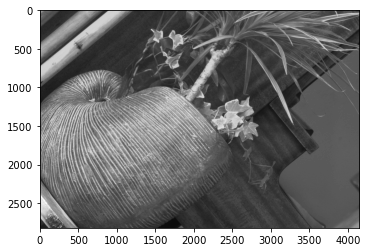

In [108]:
plt.imshow(img_i, cmap='gray')

In [110]:
#f = fits.open(r"D:\Astro\20220804\M31\light\L_M31_0126_Bin1x1_300s__0C.fit")
f = fits.open('output.fits')

In [111]:
ph = f[0]


In [112]:
for k,v in ph.header.items():
  print(k,v)

SIMPLE True
BITPIX 16
NAXIS 2
NAXIS1 4144
NAXIS2 2822
COMMENT AstroCAM generated image
OBJECT M31
INSTRUME ZWO ASI294MC Pro
DATE-OBS 2022-08-04T05:49:25
CAMERA-DATE-OBS 2022-08-04T05:49:25
EXPTIME 300.0
CCD-TEMP -0.3
XPIXSZ 4.63
YPIXSZ 4.63
XBINNING 1
YBINNING 1
XORGSUBF 0
YORGSUBF 0
EGAIN 1.00224268436432
FOCALLEN 300
JD 2459795.74265046
SWCREATE Astro Photography Tool - APT v.4.01
SBSTDVER SBFITSEXT Version 1.0
SNAPSHOT 1
SET-TEMP 0.0
IMAGETYP Light Frame
SITELAT +40 51 55.000
SITELONG -74 20 42.000
GAIN 120
OFFSET 0
BAYERPAT RGGB
BSCALE 1
BZERO 32768


In [113]:
img = ph.data

In [114]:
img.dtype, img.shape

(dtype('uint16'), (2822, 4144))

In [115]:
assert(img.shape[0]==ph.header['NAXIS2'])
assert(img.shape[1]==ph.header['NAXIS1'])

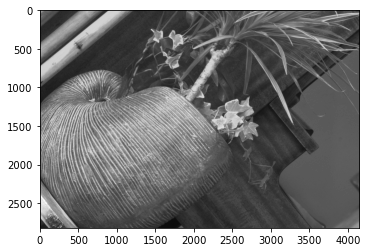

In [116]:
plt.imshow(ph.data, cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2822, 4144, 3)


True

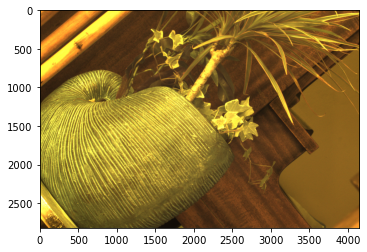

In [117]:
import torch
import importlib
from pathlib import Path

run_path = Path("../mlruns/0/cba518c62db649dfb2c4bd41ce4573ff/artifacts")
from debayer_model import DebayerModel
dm = DebayerModel('cpu', ph.data.shape)
dm.load_state_dict(torch.load(run_path / "weights_00019.pth", map_location=torch.device('cpu')))

bayered = ph.data.astype(np.float32)
bayered = np.expand_dims(np.expand_dims(bayered, axis=0), axis=0)
bayered = bayered - bayered.min()
bayered = bayered / bayered.max()
rgb_f = dm(torch.tensor(bayered))
rgb_i = (rgb_f).detach().numpy().astype(np.float32)
rgb_img = np.transpose(rgb_i[0], axes=(1, 2, 0))
print(rgb_img.shape)
plt.imshow(rgb_img)

import cv2
cv2.imwrite("output.tif", cv2.cvtColor(rgb_img, cv2.COLOR_RGB2BGR))

In [118]:
np.min(img), np.max(img), np.std(img), np.mean(img), np.median(img)

(2564, 65532, 15179.937783438363, 26363.170979739993, 23552.0)

In [119]:
def norm(img):
  img = img - np.min(img)
  img = img / np.max(img)
  return img

In [120]:
def debayer(img, method=cv2.COLOR_BAYER_BG2RGB):
  deb = cv2.cvtColor(img, method)
  norm_deb = np.stack([norm(deb[:,:,0]), norm(deb[:,:,1]), norm(deb[:,:,2])], axis=2)
  return norm_deb.astype(np.float32)

cv2.imwrite(r"C:\Users\anand\Desktop\output-default.tif", debayer(img, cv2.COLOR_BAYER_BG2RGB))
cv2.imwrite(r"C:\Users\anand\Desktop\output-ea.tif", debayer(img, cv2.COLOR_BAYER_BG2RGB_EA)) ## Edge aware
#cv2.imwrite(r"C:\Users\anand\Desktop\output-vng.tif", debayer(img, cv2.COLOR_BAYER_BG2RGB_VNG))

True

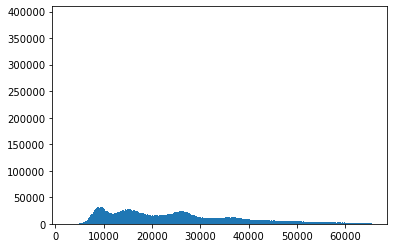

In [121]:
a,b,c = plt.hist(img.ravel(), bins=1000)

In [122]:
h = img.shape[0]
w = img.shape[1]

In [123]:
r = img[0:h:2, 0:w:2]
b = img[1:h:2, 1:w:2]
g1 = img[0:h:2, 1:w:2]
g2 = img[1:h:2, 0:w:2]
g = (g1+g2)/2

In [124]:
assert(r.shape==b.shape)
assert(r.shape==g.shape)

'min:0.0, max:1.0, mean:0.5201242595275369'

'min:0.0, max:1.0, mean:0.4054594423295565'

'min:0.0, max:1.0, mean:0.41509843028929877'

'min:0.0, max:1.0, mean:0.14301546995844194'

'min:0.0, max:1.0, mean:0.5755327900519933'

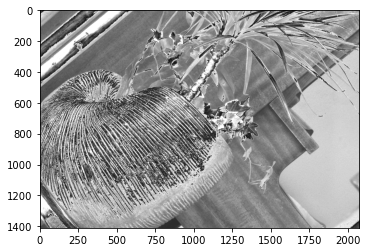

In [125]:
def info(img):
  plt.imshow(img, cmap='gray')
  display(f"min:{np.min(img)}, max:{np.max(img)}, mean:{np.mean(img)}")

info(norm(r))
info(norm(g1))
info(norm(g2))
info(norm(b))
info(norm(g))

In [126]:
cimg = np.stack([norm(r), norm(g), norm(b)], axis=2)

In [127]:
cimg.shape

(1411, 2072, 3)

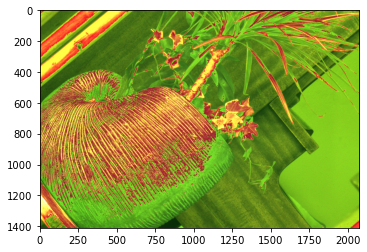

In [128]:
plt.imshow(cimg)
plt.imsave(r"C:\Users\anand\Desktop\output.png", cimg, dpi=300)

In [129]:
cv2.imwrite(r"C:\Users\anand\Desktop\output.tif", cimg.astype(np.float32))

True